In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv("vacancies.csv", delimiter=';')
df.head()

,Наименование_вакансии,Ссылка_на_вакансию,Опыт_работы,Ключевые_навыки,Зарплата
0,Data Scientist ООО ХАЙТЕКИНЖИНИРИНГ,https://hh.ru/vacancy/48101680?query=data%20sc...,1–3 года,"['Python', 'PyTorch', 'Keras', 'Tensorflow', '...",от200 000руб.довычетаналогов
1,Data Scientist (antifraud) Авито,https://hh.ru/vacancy/48120590?query=data%20sc...,3–6 лет,"['Python', 'Data Science', 'Машинное обучение']",з/пнеуказана
2,Data Scientist (команда Поиска) HeadHunter::An...,https://hh.ru/vacancy/46048820?query=data%20sc...,3–6 лет,"['Python', 'PyTorch', 'SQL', 'Machine Learning...",з/пнеуказана
3,Senior Data Scientist (Computer Vision) - Synt...,https://hh.ru/vacancy/48212689?query=data%20sc...,3–6 лет,"['Python', 'Linux', 'Английский язык', 'Comput...",з/пнеуказана
4,Системный аналитик\ data scientist HFLabs,https://hh.ru/vacancy/47688264?query=data%20sc...,1–3 года,"['Бизнес-анализ', 'SQL', 'Системный анализ', '...",от190 000до250 000руб.наруки


In [4]:
df = df.drop(["Наименование_вакансии", "Ссылка_на_вакансию"], axis=1)

In [5]:
df["Опыт_работы"].unique()

array(['1–3 года', '3–6 лет', 'не требуется', 'более 6 лет',
       'Опыт_работы'], dtype=object)

In [6]:
df = df.drop(df[df.Опыт_работы == "Опыт_работы"].index)

In [7]:
pd.DataFrame(df.Зарплата == 'з/пнеуказана').sum()

Зарплата    284
dtype: int64

In [8]:
pd.DataFrame(df.Зарплата != 'з/пнеуказана').sum()

Зарплата    62
dtype: int64

In [9]:
pd.DataFrame(df.Зарплата == None).sum()

Зарплата    0
dtype: int64

In [10]:
df_train = df.drop(df[(df.Зарплата == "з/пнеуказана") | (df.Зарплата == np.NaN)].index)

In [11]:
df_train.shape

(62, 3)

In [12]:
pd.isna(df_train['Зарплата'].index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [13]:
from pprint import pprint
skills_dict = {}
for line in df_train["Ключевые_навыки"]:    
    for skill in line.split("', '"):
        skill = skill.lower()
        if skill[:2] == "['":
            skill = skill[2:]
        elif skill[-2:] == "']":
            skill = skill[:-2]
        if skill == 'ml':
            skill = 'machine learning'
        if ' ' in skill:
            skill.replace(' ', '')
        if skill in skills_dict:
            skills_dict[skill] += 1
        elif skill != "[]":
            skills_dict[skill] = 1

skills_df = pd.DataFrame(list(skills_dict.items()), columns=["Skill", "Frequency"])

In [14]:
skills_df = skills_df.drop(skills_df[skills_df["Frequency"] == 1].index)

In [15]:
sorted_skills = skills_df.sort_values(by="Frequency", ascending=False)
sorted_skills.head(20)

,Skill,Frequency
0,python,51
12,machine learning,34
16,sql,25
43,pandas,16
1,pytorch,16
22,английский язык,15
5,deep learning,12
27,data science,10
39,numpy,10
31,математическая статистика,10


<AxesSubplot:xlabel='Frequency', ylabel='Skill'>

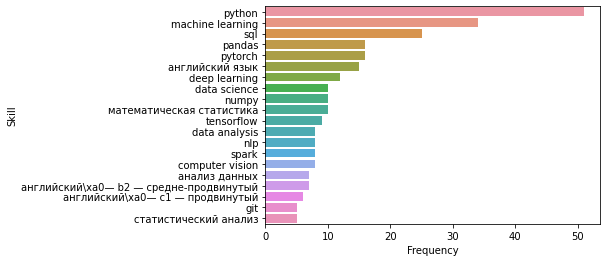

In [16]:
sns.barplot(data=sorted_skills.head(20), x="Frequency", y="Skill")

In [17]:
label_encoder = LabelEncoder()
df_train["Опыт_работы"] = label_encoder.fit_transform(df_train["Опыт_работы"])
print(dict(enumerate(label_encoder.classes_)))


{0: '1–3 года', 1: '3–6 лет', 2: 'более 6 лет', 3: 'не требуется'}


In [18]:
df_train.shape

(62, 3)

In [19]:
X = df_train.drop(['Зарплата'], axis=1)
y = df_train["Зарплата"]

In [20]:
y = y.str.extract(r'(\d+[.\d]*\s\d[.\d]*.*[рUE][уSU][бDR])')
print(y.head())



                     0
0           200 000руб
4  190 000до250 000руб
5      3 000до5 000USD
6    50 000до80 000руб
7           100 000руб


In [21]:
def get_currency(s):
    try:
        return s[-3:]
    except:
        pass
    
y = pd.DataFrame(data=y.values, columns=['Salary'])
y["Currency"] = y["Salary"].apply(get_currency)
y.shape

(62, 2)

In [22]:
import re
def get_salary(s):
    s = s[:-3]
    if "до" in s:
        s = s.split("до")
        s[0] =  "".join(re.findall(r'\d+', s[0]))
        s[1] =  "".join(re.findall(r'\d+', s[0])) 
        s = (int(s[0]) + int(s[1])) // 2
    else: 
        s = "".join(re.findall(r'\d+', s))
        s = int(s)
    
    return s


y["Salary"] = y["Salary"].apply(get_salary)
y.shape

(62, 2)

In [23]:
y.head()

,Salary,Currency
0,200000,руб
1,190000,руб
2,3000,USD
3,50000,руб
4,100000,руб


In [24]:
y_unique_currency = y.groupby('Currency')["Salary"].count()
print(y_unique_currency)
print(y.shape)

Currency
EUR     1
USD     6
руб    55
Name: Salary, dtype: int64
(62, 2)


In [25]:
X = X.reset_index(drop=True)

In [26]:
X[np.array(sorted_skills.head(20)['Skill'])] = np.nan

In [27]:
for skill in np.array(sorted_skills.head(20)['Skill']):
    X[skill] = X.apply(lambda row: 1 if skill in row['Ключевые_навыки'].lower() else 0, axis=1)

In [28]:
X["python"].value_counts()
X.drop("Ключевые_навыки", inplace=True, axis=1)
X.shape

(62, 21)

In [29]:
X.head()

,Опыт_работы,python,machine learning,sql,pandas,pytorch,английский язык,deep learning,data science,numpy,...,tensorflow,data analysis,nlp,spark,computer vision,анализ данных,английский\xa0— b2 — средне-продвинутый,английский\xa0— c1 — продвинутый,git,статистический анализ
0,0,1,1,0,0,1,0,1,0,0,...,1,0,0,0,1,1,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [30]:
y["Salary"] = y.apply(lambda x: x["Salary"] * 72.66 if x["Currency"] == 'USD' else (x['Salary'] * 85.04 if x["Currency"] == 'EUR' else x["Salary"]), axis=1) 
y.drop("Currency", inplace=True, axis=1)

In [31]:
y = y.Salary
y.shape

(62,)

In [33]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
X_train.shape

(41, 21)

In [34]:
y_train.shape

(41,)

In [56]:
from sklearn.ensemble import RandomForestRegressor
Regr = RandomForestRegressor(min_samples_split =5)

In [36]:
Regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4)

In [37]:
import matplotlib.pyplot as plt

In [38]:
Regr.score(X_test, y_test) # Не очень моделька вышла. Содержание тегов мало сказывается:C

-0.07041530191295009

21

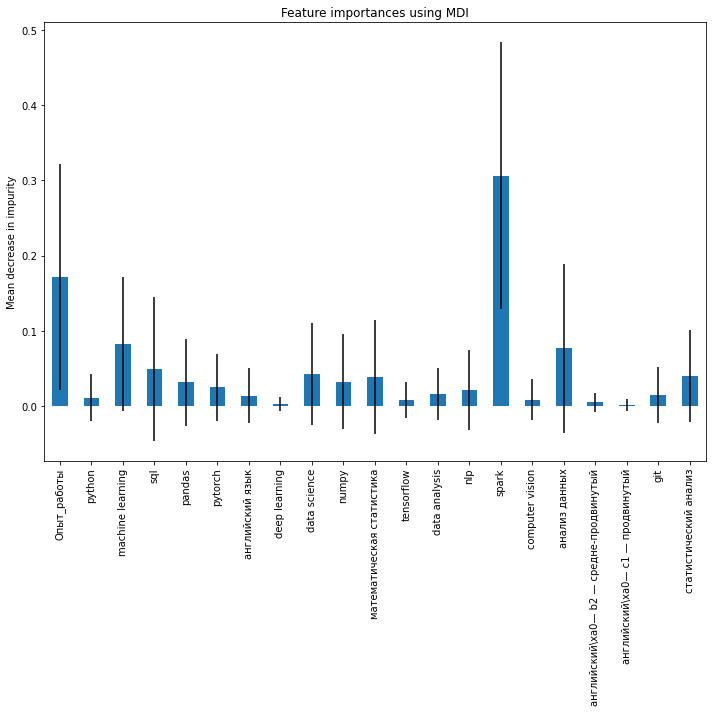

In [39]:
importances = Regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Regr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
len(std)

Попробуем покрутить модель, используя Кросс-Валидацию и поиск лучших параметров:

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import  metrics

In [69]:
parametrs = {"n_estimators": range(10, 11), 
            "max_depth": range(1, 4),
            "criterion": ["mse", "mae"]}

In [70]:
grid_search_cv_reg = GridSearchCV(Regr, parametrs, cv=5)

In [71]:
grid_search_cv_reg

GridSearchCV(cv=5, estimator=RandomForestRegressor(min_samples_split=5),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(1, 4),
                         'n_estimators': range(10, 11)})

In [72]:
grid_search_cv_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(min_samples_split=5),
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(1, 4),
                         'n_estimators': range(10, 11)})

In [77]:
grid_search_cv_reg.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=2, min_samples_split=5,
                      n_estimators=10)

In [78]:
best_reg = grid_search_cv_reg.best_estimator_
best_reg.score(X_train, y_train)

0.48537838669129296

In [79]:
best_reg.score(X_test, y_test) #Лол

0.004374491124941371

21

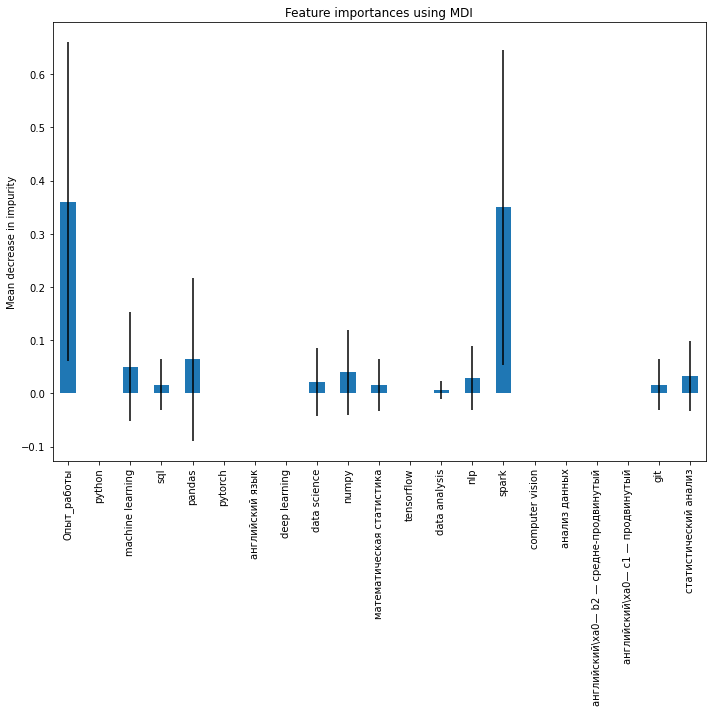

In [80]:
importances = best_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_reg.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
len(std)